In [1]:
import sqlite3 as sql
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

import scipy.optimize as optimize
from scipy import stats as sci
import math
from pprint import pprint

from collections import defaultdict
from typing import List
from tqdm import tqdm


In [2]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [3]:
db_NuMu_6_8 = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Snowstorm/22012/merged_part_1.db"
# 29386 events
db_Corsika_5_1 = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Corsika/0005000-0005999/merged_part_1.db"
# 234823 events

In [4]:
def get_table_event_count(conn: sql.Connection, table: str) -> int:
    cursor = conn.cursor()
    cursor.execute(f"SELECT COUNT(DISTINCT event_no) FROM {table}")
    event_count = cursor.fetchone()[0]
    return event_count

In [5]:
def convertDBtoDF(file:str, table:str, N_events_total:int, N_events:int = None) -> pd.DataFrame:
    con = sql.connect(file)
    if N_events is None or N_events > N_events_total:
        N_events = N_events_total
    event_no_query = f'SELECT DISTINCT event_no FROM {table} LIMIT {N_events}'
    event_nos = pd.read_sql_query(event_no_query, con)['event_no'].tolist()
    
    event_filter = ','.join(map(str, event_nos))  # Convert to comma-separated string for SQL IN clause
    query = f'SELECT * FROM {table} WHERE event_no IN ({event_filter})'
    
    df = pd.read_sql_query(query, con)
    con.close()
    
    return df

In [6]:
df_NuMu_6_8 = convertDBtoDF(db_NuMu_6_8, 'SRTInIcePulses', 2000) 
# 2500 events: 9 min 30 sec
# 2000 events: 7 min 30 sec

In [7]:
df_Corsika_5_1 = convertDBtoDF(db_Corsika_5_1, 'SRTInIcePulses', 5000)
# 2500 events: 1 min
# 5000 events: 2 min

In [9]:
def load_reference_data(filepath: str) -> np.ndarray:
    df = pd.read_csv(filepath)
    return df.values  # Convert the DataFrame to a NumPy array

In [10]:
def addStringAndDOMtoDF(df: pd.DataFrame, 
                        reference_data: np.ndarray, 
                        tolerance_xy: float = 10, 
                        tolerance_z: float = 2) -> pd.DataFrame:
    # Add `string` and `dom_number` columns if they don't exist
    if 'string' not in df.columns:
        df['string'] = None
    if 'dom_number' not in df.columns:
        df['dom_number'] = None

    # Loop through each row in the DataFrame to update `string` and `dom_number`
    for idx, row in df.iterrows():
        dom_x, dom_y, dom_z = row['dom_x'], row['dom_y'], row['dom_z']

        # Match `dom_x` and `dom_y` within specified tolerance
        matches_xy = reference_data[
            (np.abs(reference_data[:, 2] - dom_x) <= tolerance_xy) &
            (np.abs(reference_data[:, 3] - dom_y) <= tolerance_xy)
        ]

        # If any matches on x and y, proceed to check z
        if len(matches_xy) > 0:
            match_z = matches_xy[np.abs(matches_xy[:, 4] - dom_z) <= tolerance_z]

            if len(match_z) > 0:
                # Update the DataFrame row with matching `string` and `dom_number`
                df.at[idx, 'string'] = int(match_z[0, 0])
                df.at[idx, 'dom_number'] = int(match_z[0, 1])

    return df


In [12]:
# add string and dom_number to the dataframes

In [13]:
ref_dom_pos = load_reference_data('/groups/icecube/cyan/factory/DOMification/unique_string_dom_completed.csv')

In [ ]:
addStringAndDOMtoDF(df_NuMu_6_8, ref_dom_pos)
addStringAndDOMtoDF(df_Corsika_5_1, ref_dom_pos)
# 45 min

,charge,dom_time,width,dom_x,dom_y,dom_z,pmt_area,rde,is_bright_dom,is_bad_dom,is_saturated_dom,is_errata_dom,event_time,hlc,awtd,string,pmt_number,dom_number,dom_type,event_no
0,1.575,11353.0,8.0,-9.130000,-481.73999,-470.950012,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,56783.915364,0.0,0.0,3.0,0.0,58.0,20.0,0
1,0.325,10289.0,1.0,114.389999,-461.98999,-250.250000,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,56783.915364,1.0,1.0,4.0,0.0,45.0,20.0,0
2,0.625,10892.0,1.0,114.389999,-461.98999,-284.290009,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,56783.915364,1.0,1.0,4.0,0.0,47.0,20.0,0
3,0.875,10133.0,1.0,114.389999,-461.98999,-352.369995,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,56783.915364,1.0,1.0,4.0,0.0,51.0,20.0,0
4,1.125,10184.0,1.0,114.389999,-461.98999,-352.369995,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,56783.915364,1.0,1.0,4.0,0.0,51.0,20.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5134241,0.875,12425.0,1.0,-10.970000,6.72000,-409.309998,0.0444,1.35,-1.0,-1.0,-1.0,0.0,56783.915364,1.0,1.0,86.0,0.0,47.0,20.0,4999
5134242,1.025,14250.0,8.0,-10.970000,6.72000,-423.329987,0.0444,1.35,-1.0,-1.0,-1.0,0.0,56783.915364,0.0,0.0,86.0,0.0,49.0,20.0,4999
5134243,0.475,14282.0,8.0,-10.970000,6.72000,-423.329987,0.0444,1.35,-1.0,-1.0,-1.0,0.0,56783.915364,0.0,0.0,86.0,0.0,49.0,20.0,4999
5134244,0.875,13067.0,8.0,-10.970000,6.72000,-451.359985,0.0444,1.35,-1.0,-1.0,-1.0,0.0,56783.915364,0.0,0.0,86.0,0.0,53.0,20.0,4999


In [16]:
df_NuMu_6_8

,charge,dom_time,width,dom_x,dom_y,dom_z,pmt_area,rde,is_bright_dom,is_bad_dom,is_saturated_dom,is_errata_dom,event_time,hlc,awtd,string,pmt_number,dom_number,dom_type,event_no
0,0.675,14581.0,8.0,576.37,170.92,-271.89,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,59000.171844,0.0,0.0,50.0,0.0,46.0,20.0,0
1,1.275,9863.0,1.0,-234.95,140.44,312.84,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,59000.171844,1.0,1.0,53.0,0.0,12.0,20.0,0
2,0.475,10097.0,8.0,-234.95,140.44,295.82,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,59000.171844,1.0,0.0,53.0,0.0,13.0,20.0,0
3,0.825,10338.0,4.0,-234.95,140.44,278.79,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,59000.171844,1.0,1.0,53.0,0.0,14.0,20.0,0
4,0.775,10486.0,1.0,-111.51,159.98,262.24,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,59000.171844,1.0,1.0,54.0,0.0,15.0,20.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16162099,0.775,12685.0,8.0,72.37,-66.60,-440.17,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,59000.171844,0.0,0.0,80.0,0.0,51.0,20.0,1999
16162100,0.725,13096.0,1.0,72.37,-66.60,-461.20,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,59000.171844,1.0,1.0,80.0,0.0,54.0,20.0,1999
16162101,0.675,12155.0,1.0,72.37,-66.60,-475.22,0.0444,1.00,-1.0,-1.0,-1.0,-1.0,59000.171844,1.0,1.0,80.0,0.0,56.0,20.0,1999
16162102,1.275,12839.0,8.0,113.19,-60.47,-469.48,0.0444,1.35,-1.0,-1.0,-1.0,-1.0,59000.171844,0.0,0.0,83.0,0.0,55.0,20.0,1999


In [17]:
# pick the event that has most pulses
def getLargestEvent(df: pd.DataFrame) -> pd.DataFrame:
    event_no = df['event_no'].value_counts().idxmax()
    return df[df['event_no'] == event_no]

In [ ]:
df_NuMu_6_8_largest = getLargestEvent(df_NuMu_6_8)
# 13 sec

In [20]:
df_NuMu_6_8_largest.columns

Index(['charge', 'dom_time', 'width', 'dom_x', 'dom_y', 'dom_z', 'pmt_area',
       'rde', 'is_bright_dom', 'is_bad_dom', 'is_saturated_dom',
       'is_errata_dom', 'event_time', 'hlc', 'awtd', 'string', 'pmt_number',
       'dom_number', 'dom_type', 'event_no'],
      dtype='object')

In [29]:
def buildCountTablePerEachStringDom(df: pd.DataFrame) -> pd.DataFrame:
    # Group by 'string' and 'dom_number' and aggregate counts and positional data
    count_table = df.groupby(['string', 'dom_number']).agg(
        count=('event_no', 'size'),   # Count occurrences for each (string, dom_number) pair
        dom_x=('dom_x', 'first'),     # Get the first instance of dom_x
        dom_y=('dom_y', 'first'),     # Get the first instance of dom_y
        dom_z=('dom_z', 'first')      # Get the first instance of dom_z
    ).reset_index()
    
    # Calculate the normalised count
    max_count = count_table['count'].max()
    count_table['normalised_count'] = count_table['count'] / max_count
    
    return count_table


In [30]:
dom_count_largest_NuMu_6_8 = buildCountTablePerEachStringDom(df_NuMu_6_8_largest)
# 5 sec

In [31]:
dom_count_largest_NuMu_6_8

,string,dom_number,count,dom_x,dom_y,dom_z,normalised_count
0,1.0,40.0,1,-256.14,-521.08,-167.78,0.003953
1,1.0,41.0,2,-256.14,-521.08,-184.80,0.007905
2,1.0,42.0,1,-256.14,-521.08,-201.82,0.003953
3,1.0,47.0,3,-256.14,-521.08,-286.92,0.011858
4,1.0,48.0,4,-256.14,-521.08,-303.95,0.015810
...,...,...,...,...,...,...,...
2190,86.0,56.0,98,-10.97,6.72,-472.39,0.387352
2191,86.0,57.0,95,-10.97,6.72,-479.39,0.375494
2192,86.0,58.0,123,-10.97,6.72,-486.40,0.486166
2193,86.0,59.0,117,-10.97,6.72,-493.41,0.462451


In [60]:
def plotDOMHeatmap(df_original, elev=60, azim=110, fileName = None):
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': '3d'})
    df = df_original.copy()
    df = df[df['normalised_count'] > 0.7]  # Filter out DOMs with zero counts
    # Scatter plot using dom_x, dom_y, dom_z with color based on normalised_count
    sc = ax.scatter(df['dom_x'], df['dom_y'], df['dom_z'], 
                    c=df['normalised_count'], cmap='cool', s=20)
    
    # Colour bar to show the scale of normalised_count
    cbar = fig.colorbar(sc, ax=ax, pad=0.1, shrink=0.6, aspect=10)
    cbar.set_label('Normalised Count')
    
    # Setting labels and viewing angle
    ax.set_xlabel('DOM X')
    ax.set_ylabel('DOM Y')
    ax.set_zlabel('DOM Z')
    ax.set_title("3D Heatmap of DOM Positions with Normalised Count Colourmap")
    ax.view_init(elev=elev, azim=azim)
    
    # Compute statistics
    d = {
        'N': len(df),
        'Max Count': df['count'].max(),
        'Min Count': df['count'].min(),
        'Mean Count': df['count'].mean(),
        'Std Dev': df['count'].std()
    }
    
    # Format the statistics into a multi-line string
    stats_text = "\n".join([f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}" for key, value in d.items()])
    
    # Display the text on the plot
    ax.text2D(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    plt.savefig(fileName, format='pdf')

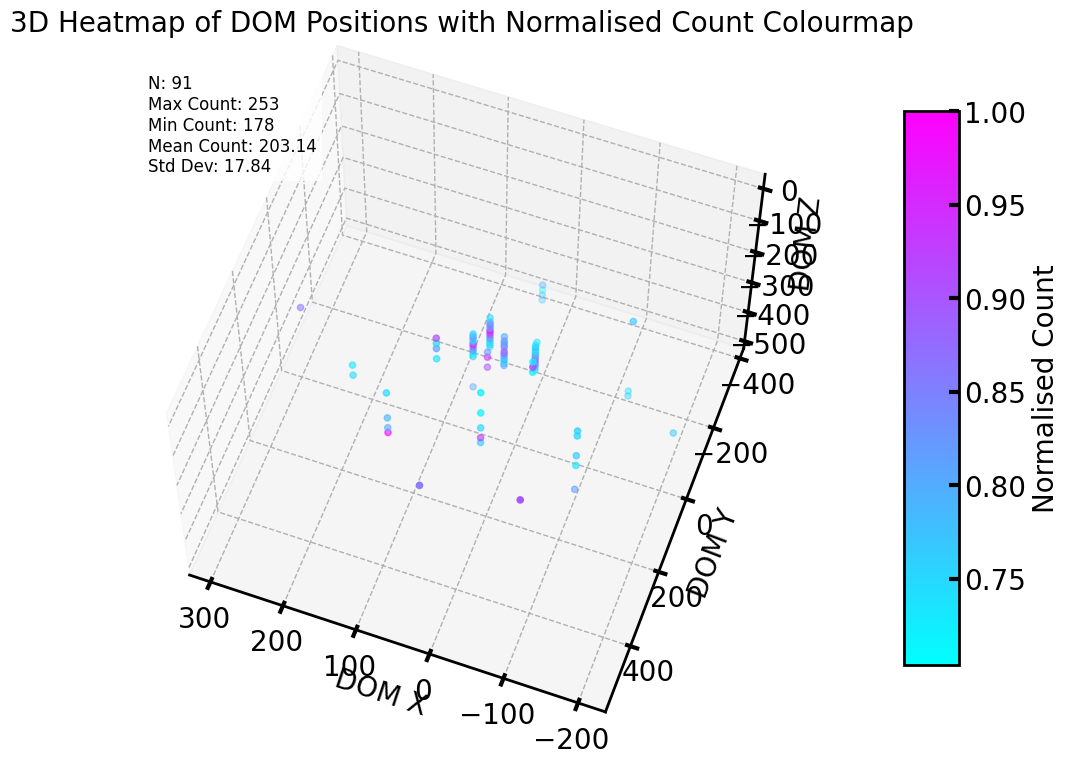

In [62]:
plotDOMHeatmap(dom_count_largest_NuMu_6_8, elev=60, azim=110, fileName = 'DOM_Heat_NuMu_6_8_masked.pdf')
# 30 sec